In [1]:
import pandas as pd
from src import *
from scipy.optimize import minimize

# Read Data

In [2]:
predicted_returns = pd.read_pickle("data/pred_ret_Least Correlated 15.pkl")

In [3]:
predicted_returns = pd.read_pickle("data/pred_ret_arima.pkl").dropna().apply(pd.to_numeric)

In [4]:
price = pd.read_pickle("data/price.pkl")["adj_close"].unstack("ticker")
price = fill_price_dates(price, droplevel=False).ffill()
price.shape

(8822, 392)

# Find top / bottom decile for long / short position

In [5]:
start_date = datetime(2007, 1, 1)
position_indicator = calc_position_by_rank(
    df_price=price, 
    df_ratio=predicted_returns.loc[start_date:].unstack("ticker"),
    rank_formula="predicted_ret",
    lb=0,
    ub=0.1,
    interval=None,
    use_change=False,
)
position_indicator

ticker,A,AAL,AAPL,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,FTV,LW,IR,DOW,UBER,CTVA,HWM,CARR,ABNB,CEG
date,,,,,,,,,,,,,,,,,,,,,
2007-06-30,0,1,1,0,0,0,0,0,1,-1,...,0,0,0,0,0,0,0,0,0,0
2007-07-31,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-08-31,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-09-30,0,0,0,0,0,0,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-10-31,0,0,0,0,-1,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2023-10-31,0,0,-1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2023-11-30,0,0,-1,0,0,0,0,0,1,0,...,0,0,0,0,-1,0,0,0,-1,0


# Markowitz optimize position

In [6]:
def portfolio_markov(position_indicator,price,PORTFOLIO_VALUE):
    
    def optimize_portfolio(weights, cov_matrix):
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        return portfolio_variance

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 

    dates = list(position_indicator.index)
    tickers = list(position_indicator.columns)

    position = pd.DataFrame(index=dates, columns=tickers)

    for date in dates:
        active_tickers = position_indicator.loc[date].loc[lambda x: x != 0].index
        active_prices = price.loc[date, active_tickers]
        active_indicator = position_indicator.loc[date, active_tickers]

        cov_matrix = price[active_tickers].pct_change().cov()

        num_assets = len(active_tickers)
        initial_guess = np.array(num_assets * [1. / num_assets,])
        bounds = tuple((0, 1) for asset in range(num_assets))
        optimized = minimize(optimize_portfolio, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

        optimized_weights = optimized.x
        long_short_factor = active_indicator.map({1: 1, -1: -1})
        capital_allocation = long_short_factor * optimized_weights * PORTFOLIO_VALUE
        stock_positions = capital_allocation / active_prices

        position.loc[date, active_tickers] = stock_positions

    position = position.apply(pd.to_numeric).fillna(0)
    
    return position

In [7]:
INIT_CAPITAL=1e6
position = portfolio_markov(position_indicator=position_indicator,
                            price=price,
                            PORTFOLIO_VALUE = INIT_CAPITAL)

# Run backtest with All Position Change

<Axes: >

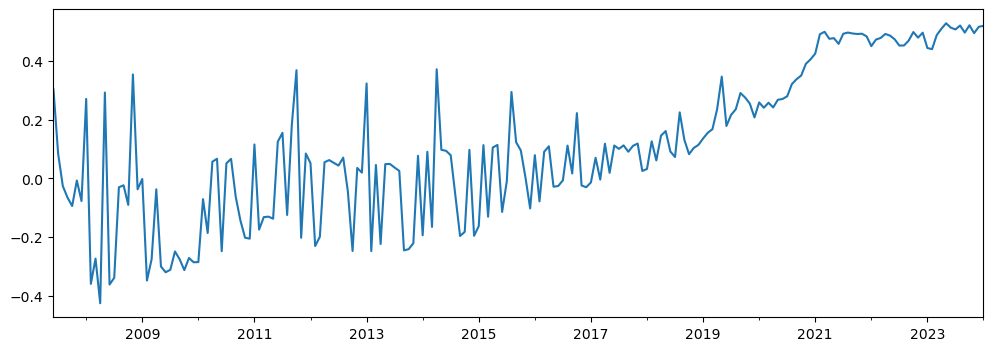

In [8]:
trade_cls = CalcTrade(
    df_price=price,
    init_cap=INIT_CAPITAL,
    adj_small_change=True
)
summary_df = trade_cls.iter_dates(position=position)
summary_df["total_ret"].plot(figsize=(12,4))

In [9]:
df_ff = get_ff_data()

pd.Series({
    **eval_return(summary_df["total_ret"], df_ff=df_ff, ann_factor=12),
    **ff_decomposition(summary_df["total_ret"], df_ff=df_ff, ann_factor=12)
}) 

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>